# 📊 Amazon Sales Data Analysis & Insights

## Business Intelligence Dashboard
**Objective:** Analyze processed data from the Dagster pipeline to extract business insights and create visualizations.

**Key Questions to Answer:**
- Which month was most profitable?
- What are the daily order patterns by status?
- Which product categories perform best?
- What geographical trends exist in sales?

**Data Source:** DuckDB tables created by Dagster pipeline:
- `raw_amazon_sales` - Clean sales data
- `monthly_revenue` - Monthly revenue by category  
- `daily_orders` - Daily order counts by status

**Note:** This notebook focuses on data analysis and visualization. The data pipeline is handled separately by Dagster Python modules.

## 📦 Import Required Libraries

In [5]:
# Data analysis and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Database connection
import duckdb

# Utility libraries
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Analysis libraries imported successfully")
print("📊 Ready for data analysis and visualization")

✅ Analysis libraries imported successfully
📊 Ready for data analysis and visualization


## 🔌 Connect to DuckDB Database

In [6]:
# Connect to the DuckDB database created by Dagster pipeline
db_path = "../data/sales.duckdb"

try:
    conn = duckdb.connect(db_path)
    print(f"✅ Connected to DuckDB: {db_path}")
    
    # Check available tables
    tables = conn.execute("SHOW TABLES").fetchall()
    print(f"📊 Available tables: {len(tables)}")
    for table in tables:
        table_name = table[0]
        count = conn.execute(f"SELECT COUNT(*) FROM {table_name}").fetchone()[0]
        print(f"  • {table_name}: {count:,} records")
        
except Exception as e:
    print(f"❌ Error connecting to database: {e}")
    print("💡 Make sure the Dagster pipeline has been executed first!")

✅ Connected to DuckDB: ../data/sales.duckdb
📊 Available tables: 3
  • daily_orders: 457 records
  • monthly_revenue: 30 records
  • raw_amazon_sales: 386,925 records
📊 Available tables: 3
  • daily_orders: 457 records
  • monthly_revenue: 30 records
  • raw_amazon_sales: 386,925 records


## 📈 Monthly Revenue Analysis

In [7]:
# Load monthly revenue data
monthly_revenue_query = """
SELECT 
    year_month,
    category,
    total_revenue,
    order_count,
    avg_order_value
FROM monthly_revenue
ORDER BY year_month, total_revenue DESC
"""

df_monthly = pd.read_sql(monthly_revenue_query, conn)
print(f"📊 Loaded {len(df_monthly)} monthly revenue records")

# Display sample data
print("\n🔍 Sample Monthly Revenue Data:")
print(df_monthly.head(10))

# Calculate totals by month
monthly_totals = df_monthly.groupby('year_month').agg({
    'total_revenue': 'sum',
    'order_count': 'sum'
}).reset_index()

print(f"\n💰 Monthly Revenue Totals:")
for _, row in monthly_totals.iterrows():
    print(f"  • {row['year_month']}: ${row['total_revenue']:,.0f} ({row['order_count']:,} orders)")

📊 Loaded 30 monthly revenue records

🔍 Sample Monthly Revenue Data:
  year_month       category  total_revenue  order_count  avg_order_value
0    2022-03            Set       154596.0          195           792.80
1    2022-03          kurta        99024.0          213           464.90
2    2022-03  Western Dress        16437.0           18           913.17
3    2022-03            Top        13533.0           27           501.22
4    2022-03         Blouse          840.0            3           280.00
5    2022-04            Set     42372099.0        50397           840.77
6    2022-04          kurta     21718614.0        49128           442.08
7    2022-04  Western Dress      8049558.0        10689           753.07
8    2022-04            Top      5018676.0        10203           491.88
9    2022-04   Ethnic Dress       691893.0          888           779.16

💰 Monthly Revenue Totals:
  • 2022-03: $284,430 (456 orders)
  • 2022-04: $78,703,560 (123,018 orders)
  • 2022-05: $71,860,602 

In [8]:
# 🏆 IDENTIFY MOST PROFITABLE MONTH
most_profitable_month = monthly_totals.loc[monthly_totals['total_revenue'].idxmax()]

print("🏆 MOST PROFITABLE MONTH ANALYSIS:")
print("=" * 50)
print(f"📅 Month: {most_profitable_month['year_month']}")
print(f"💰 Total Revenue: ${most_profitable_month['total_revenue']:,.0f}")
print(f"📦 Total Orders: {most_profitable_month['order_count']:,}")
print(f"💵 Average Order Value: ${most_profitable_month['total_revenue']/most_profitable_month['order_count']:,.0f}")

# Create monthly revenue visualization
fig = px.bar(monthly_totals, 
             x='year_month', 
             y='total_revenue',
             title='📈 Monthly Revenue Comparison',
             labels={'total_revenue': 'Total Revenue ($)', 'year_month': 'Month'},
             color='total_revenue',
             color_continuous_scale='Blues')

fig.update_layout(
    showlegend=False,
    xaxis_title="Month",
    yaxis_title="Total Revenue ($)",
    height=400
)

# Highlight most profitable month
fig.add_annotation(
    x=most_profitable_month['year_month'],
    y=most_profitable_month['total_revenue'],
    text=f"Most Profitable<br>${most_profitable_month['total_revenue']:,.0f}",
    showarrow=True,
    arrowhead=2,
    arrowcolor="red",
    bgcolor="yellow",
    bordercolor="red"
)

fig.show()

🏆 MOST PROFITABLE MONTH ANALYSIS:
📅 Month: 2022-04
💰 Total Revenue: $78,703,560
📦 Total Orders: 123,018
💵 Average Order Value: $640


## 📦 Daily Orders Analysis

In [9]:
# Load daily orders data
daily_orders_query = """
SELECT 
    order_date,
    status,
    order_count,
    total_quantity,
    total_amount
FROM daily_orders
ORDER BY order_date, status
"""

df_daily = pd.read_sql(daily_orders_query, conn)
df_daily['order_date'] = pd.to_datetime(df_daily['order_date'])

print(f"📊 Loaded {len(df_daily)} daily order records")
print(f"📅 Date range: {df_daily['order_date'].min()} to {df_daily['order_date'].max()}")

# Summary by order status
status_summary = df_daily.groupby('status').agg({
    'order_count': 'sum',
    'total_quantity': 'sum', 
    'total_amount': 'sum'
}).reset_index()

print(f"\n📋 Orders Summary by Status:")
for _, row in status_summary.iterrows():
    print(f"  • {row['status']}: {row['order_count']:,} orders, ${row['total_amount']:,.0f} total")

📊 Loaded 457 daily order records
📅 Date range: 2022-03-31 00:00:00 to 2022-06-29 00:00:00

📋 Orders Summary by Status:
  • Cancelled: 54,996 orders, $20,757,853 total
  • Pending: 1,974 orders, $1,290,813 total
  • Pending - Waiting for Pick Up: 843 orders, $576,414 total
  • Shipped: 233,412 orders, $150,972,765 total
  • Shipped - Damaged: 3 orders, $3,408 total
  • Shipped - Delivered to Buyer: 86,307 orders, $55,952,445 total
  • Shipped - Lost in Transit: 15 orders, $5,991 total
  • Shipped - Out for Delivery: 105 orders, $80,913 total
  • Shipped - Picked Up: 2,919 orders, $1,983,756 total
  • Shipped - Rejected by Buyer: 33 orders, $21,885 total
  • Shipped - Returned to Seller: 5,859 orders, $3,808,932 total
  • Shipped - Returning to Seller: 435 orders, $322,860 total
  • Shipping: 24 orders, $0 total


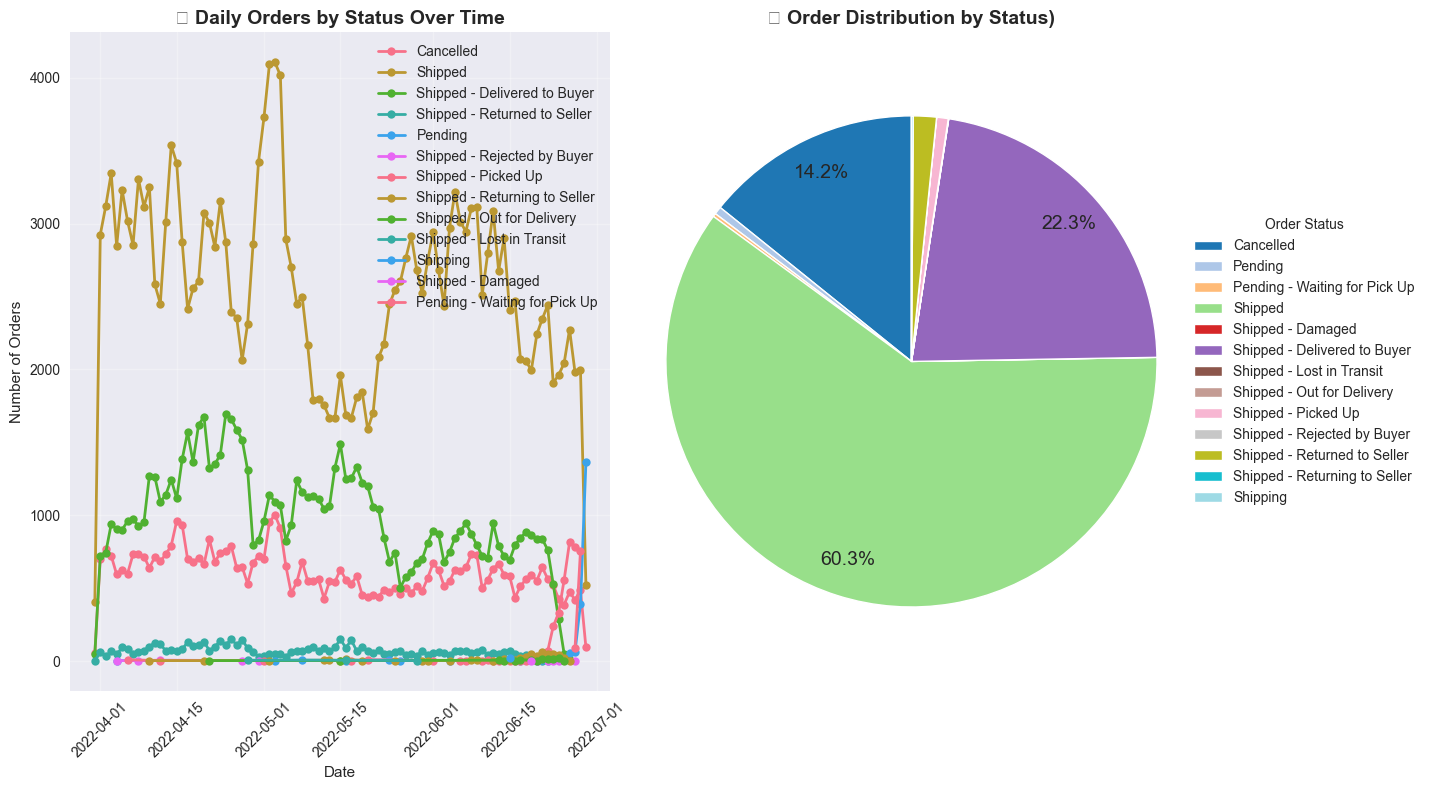

In [19]:
# Create daily orders by status visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Daily orders time series by status
for status in df_daily['status'].unique():
    status_data = df_daily[df_daily['status'] == status]
    ax1.plot(status_data['order_date'], status_data['order_count'], 
             marker='o', label=status, linewidth=2, markersize=6)

ax1.set_title('📦 Daily Orders by Status Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Orders')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

cmap = plt.cm.tab20
colors = cmap(np.linspace(0, 1, 13))
wedges, texts, autotexts = ax2.pie(
    pie_data.values, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors,
    pctdistance=0.85,  
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
# --- FIX IMPLEMENTED HERE: Hide labels for small slices ---
min_percentage_to_show = 3.0 

for text in autotexts:
    # 1. Extract the percentage value from the text string (e.g., '3.5%')
    percentage_str = text.get_text().replace('%', '')
    try:
        percentage = float(percentage_str)
    except ValueError:
        percentage = 0.0
    
    # 2. Check if the percentage is below the threshold
    if percentage < min_percentage_to_show:
        text.set_visible(False) # Hide the label
    else:
        text.set_fontsize(8) # Keep the reduced font size for visible labels

for text in autotexts:
    text.set_fontsize(14) 

ax2.legend(wedges, pie_data.index,
          title="Order Status",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1)) 

ax2.set_title(f'📊 Order Distribution by Status)', fontsize=14, fontweight='bold')
ax2.axis('equal') 

plt.tight_layout(rect=[0, 0, 0.9, 1])

## 🎯 Product Category Performance

In [20]:
# Analyze category performance
category_performance = df_monthly.groupby('category').agg({
    'total_revenue': 'sum',
    'order_count': 'sum',
    'avg_order_value': 'mean'
}).round(2).sort_values('total_revenue', ascending=False)

print("🏆 TOP PERFORMING CATEGORIES:")
print("=" * 40)
for category, row in category_performance.head(10).iterrows():
    print(f"📦 {category}:")
    print(f"   💰 Revenue: ${row['total_revenue']:,.0f}")
    print(f"   📊 Orders: {row['order_count']:,}")
    print(f"   💵 Avg Order: ${row['avg_order_value']:.0f}")
    print()

# Category revenue visualization
fig = px.bar(category_performance.head(10).reset_index(), 
             x='category', 
             y='total_revenue',
             title='🎯 Top 10 Categories by Revenue',
             labels={'total_revenue': 'Total Revenue ($)', 'category': 'Product Category'},
             color='total_revenue',
             color_continuous_scale='Viridis')

fig.update_xaxes(tickangle=45)
fig.update_layout(height=500, showlegend=False)
fig.show()

# Monthly category trends for top categories
top_categories = category_performance.head(5).index.tolist()
monthly_category_trends = df_monthly[df_monthly['category'].isin(top_categories)]

fig = px.line(monthly_category_trends, 
              x='year_month', 
              y='total_revenue', 
              color='category',
              title='📈 Monthly Revenue Trends for Top 5 Categories',
              labels={'total_revenue': 'Total Revenue ($)', 'year_month': 'Month'})

fig.update_layout(height=400)
fig.show()

🏆 TOP PERFORMING CATEGORIES:
📦 Set:
   💰 Revenue: $107,195,019
   📊 Orders: 125,490.0
   💵 Avg Order: $840

📦 kurta:
   💰 Revenue: $58,277,610
   📊 Orders: 124,992.0
   💵 Avg Order: $468

📦 Western Dress:
   💰 Revenue: $30,628,770
   📊 Orders: 39,414.0
   💵 Avg Order: $810

📦 Top:
   💰 Revenue: $14,712,198
   📊 Orders: 27,486.0
   💵 Avg Order: $534

📦 Ethnic Dress:
   💰 Revenue: $2,198,232
   📊 Orders: 2,943.0
   💵 Avg Order: $751

📦 Blouse:
   💰 Revenue: $1,255,167
   📊 Orders: 2,352.0
   💵 Avg Order: $481

📦 Bottom:
   💰 Revenue: $406,359
   📊 Orders: 1,101.0
   💵 Avg Order: $367

📦 Saree:
   💰 Revenue: $344,082
   📊 Orders: 426.0
   💵 Avg Order: $819

📦 Dupatta:
   💰 Revenue: $2,745
   📊 Orders: 9.0
   💵 Avg Order: $305



## 🗺️ Geographical Analysis

In [21]:
# Geographical analysis from raw data
geo_query = """
SELECT 
    ship_state,
    ship_city,
    COUNT(*) as order_count,
    SUM(amount) as total_revenue,
    AVG(amount) as avg_order_value
FROM raw_amazon_sales 
WHERE status != 'Cancelled' AND amount > 0
GROUP BY ship_state, ship_city
ORDER BY total_revenue DESC
"""

df_geo = pd.read_sql(geo_query, conn)

# State-level analysis
state_analysis = df_geo.groupby('ship_state').agg({
    'order_count': 'sum',
    'total_revenue': 'sum',
    'avg_order_value': 'mean'
}).round(2).sort_values('total_revenue', ascending=False)

print("🗺️ TOP STATES BY REVENUE:")
print("=" * 35)
for state, row in state_analysis.head(10).iterrows():
    if pd.notna(state) and state.strip():
        print(f"📍 {state}:")
        print(f"   💰 Revenue: ${row['total_revenue']:,.0f}")
        print(f"   📊 Orders: {row['order_count']:,}")
        print(f"   💵 Avg Order: ${row['avg_order_value']:.0f}")
        print()

# Top cities analysis
top_cities = df_geo.head(15)
print("🏙️ TOP CITIES BY REVENUE:")
print("=" * 30)
for _, row in top_cities.iterrows():
    if pd.notna(row['ship_city']) and row['ship_city'].strip():
        city_state = f"{row['ship_city']}, {row['ship_state']}" if pd.notna(row['ship_state']) else row['ship_city']
        print(f"🏢 {city_state}: ${row['total_revenue']:,.0f} ({row['order_count']} orders)")

# Visualize top states
top_states = state_analysis.head(10).reset_index()
fig = px.bar(top_states, 
             x='ship_state', 
             y='total_revenue',
             title='🗺️ Top 10 States by Revenue',
             labels={'total_revenue': 'Total Revenue ($)', 'ship_state': 'State'},
             color='total_revenue',
             color_continuous_scale='Blues')

fig.update_xaxes(tickangle=45)
fig.update_layout(height=500, showlegend=False)
fig.show()

🗺️ TOP STATES BY REVENUE:
📍 MAHARASHTRA:
   💰 Revenue: $36,674,310
   📊 Orders: 56,511.0
   💵 Avg Order: $646

📍 KARNATAKA:
   💰 Revenue: $28,949,943
   📊 Orders: 44,238.0
   💵 Avg Order: $643

📍 TELANGANA:
   💰 Revenue: $18,870,384
   📊 Orders: 28,572.0
   💵 Avg Order: $642

📍 UTTAR PRADESH:
   💰 Revenue: $18,559,968
   📊 Orders: 26,370.0
   💵 Avg Order: $698

📍 TAMIL NADU:
   💰 Revenue: $17,863,047
   📊 Orders: 29,100.0
   💵 Avg Order: $605

📍 DELHI:
   💰 Revenue: $11,718,267
   📊 Orders: 17,157.0
   💵 Avg Order: $708

📍 KERALA:
   💰 Revenue: $10,131,963
   📊 Orders: 15,984.0
   💵 Avg Order: $635

📍 WEST BENGAL:
   💰 Revenue: $9,621,639
   📊 Orders: 14,892.0
   💵 Avg Order: $639

📍 ANDHRA PRADESH:
   💰 Revenue: $8,646,618
   📊 Orders: 13,401.0
   💵 Avg Order: $654

📍 HARYANA:
   💰 Revenue: $7,962,822
   📊 Orders: 11,235.0
   💵 Avg Order: $725

🏙️ TOP CITIES BY REVENUE:
🏢 BENGALURU, KARNATAKA: $19,059,000 (29052 orders)
🏢 HYDERABAD, TELANGANA: $13,475,667 (20364 orders)
🏢 MUMBAI, MAHA

## 📊 Business Intelligence Summary

In [22]:
# Generate comprehensive business intelligence summary
print("📊 AMAZON SALES BUSINESS INTELLIGENCE DASHBOARD")
print("=" * 55)

# Key Performance Indicators
total_revenue = monthly_totals['total_revenue'].sum()
total_orders = monthly_totals['order_count'].sum()
avg_order_value = total_revenue / total_orders if total_orders > 0 else 0

print(f"\n💰 FINANCIAL OVERVIEW:")
print(f"• Total Revenue: ${total_revenue:,.0f}")
print(f"• Total Orders: {total_orders:,}")
print(f"• Average Order Value: ${avg_order_value:.0f}")
print(f"• Revenue Growth Period: {df_daily['order_date'].min().strftime('%B %Y')} - {df_daily['order_date'].max().strftime('%B %Y')}")

print(f"\n🏆 KEY FINDINGS:")
print(f"• Most Profitable Month: {most_profitable_month['year_month']} (${most_profitable_month['total_revenue']:,.0f})")
print(f"• Top Product Category: {category_performance.index[0]} (${category_performance.iloc[0]['total_revenue']:,.0f})")
print(f"• Top State: {state_analysis.index[0]} (${state_analysis.iloc[0]['total_revenue']:,.0f})")
print(f"• Average Daily Orders: {df_daily.groupby('order_date')['order_count'].sum().mean():.0f}")

print(f"\n📈 ORDER STATUS BREAKDOWN:")
for _, row in status_summary.iterrows():
    percentage = (row['order_count'] / total_orders) * 100
    print(f"• {row['status']}: {row['order_count']:,} orders ({percentage:.1f}%)")

print(f"\n🎯 BUSINESS RECOMMENDATIONS:")
print(f"• Focus marketing efforts in {most_profitable_month['year_month']} - highest conversion period")
print(f"• Expand {category_performance.index[0]} product line - top revenue generator")
print(f"• Prioritize logistics in {state_analysis.index[0]} - highest revenue state")
print(f"• Investigate cancelled orders ({status_summary[status_summary['status']=='Cancelled']['order_count'].iloc[0]:,} orders) for improvement opportunities")

print(f"\n✅ DATA QUALITY METRICS:")
print(f"• Data Coverage: {df_daily['order_date'].nunique()} unique days")
print(f"• Total Records Analyzed: {total_orders:,}")
print(f"• Geographic Coverage: {state_analysis.shape[0]} states, {df_geo.shape[0]} cities")

# Close database connection
conn.close()
print(f"\n🔒 Database connection closed")
print(f"📋 Analysis completed successfully!")

📊 AMAZON SALES BUSINESS INTELLIGENCE DASHBOARD

💰 FINANCIAL OVERVIEW:
• Total Revenue: $215,020,182
• Total Orders: 324,213
• Average Order Value: $663
• Revenue Growth Period: March 2022 - June 2022

🏆 KEY FINDINGS:
• Most Profitable Month: 2022-04 ($78,703,560)
• Top Product Category: Set ($107,195,019)
• Top State: MAHARASHTRA ($36,674,310)
• Average Daily Orders: 4252

📈 ORDER STATUS BREAKDOWN:
• Cancelled: 54,996 orders (17.0%)
• Pending: 1,974 orders (0.6%)
• Pending - Waiting for Pick Up: 843 orders (0.3%)
• Shipped: 233,412 orders (72.0%)
• Shipped - Damaged: 3 orders (0.0%)
• Shipped - Delivered to Buyer: 86,307 orders (26.6%)
• Shipped - Lost in Transit: 15 orders (0.0%)
• Shipped - Out for Delivery: 105 orders (0.0%)
• Shipped - Picked Up: 2,919 orders (0.9%)
• Shipped - Rejected by Buyer: 33 orders (0.0%)
• Shipped - Returned to Seller: 5,859 orders (1.8%)
• Shipped - Returning to Seller: 435 orders (0.1%)
• Shipping: 24 orders (0.0%)

🎯 BUSINESS RECOMMENDATIONS:
• Focus ma